# Step-by-step demonstration

## Lib Imports and configurations

In [1]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss
from itertools import islice

sys.path.append("Codes/")

import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format


## Loading event log

In [2]:
# Mapping all event_logs paths
logs_path = glob.glob("Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange/*/*/*/*/*.mxml.gz")

# Temp filter
logs_path = [x for x in logs_path if "_2" not in x and "_5" not in x and "Size1" in x and "Atomic" in x]

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path)

How many logs?  13


,0
0,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalMove\output\ConditionalMove.mxml.gz
1,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalRemoval\output\ConditionalRemoval.mxml.gz
2,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalToSequence\output\ConditionalToSequence.mxml.gz
3,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\Frequency\output\Frequency.mxml.gz
4,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\Loop\output\Loop.mxml.gz
5,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelMove\output\ParallelMove.mxml.gz
6,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelRemoval\output\ParallelRemoval.mxml.gz
7,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelToSequence\output\ParallelToSequence.mxml.gz
8,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\SerialMove\output\SerialMove.mxml.gz
9,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\SerialRemoval\output\SerialRemoval.mxml.gz


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

In [3]:
# Loading first event log
log_path = logs_path[4]
print(log_path)
print(log_path.split("\\")[-5] + "/" + log_path.split("\\")[-1].split(".")[0])
event_log = TMPD_utils.parse_mxml(log_path, gzip=True)

# This is a specifc step for this event log that remove an activity that shows where the drift happens
event_log = event_log[event_log['WorkflowModelElement'] != 'DRIFT_PO']

# Save original event index
event_log = event_log.reset_index(names='original_index') 

# Create an id based on the order of the event in the raw event log
event_log["Event_order_id"] = event_log.index

# Showing loaded event log
print("Total events: ", len(event_log))
print("Total cases: ", len(event_log.groupby('CaseId')))
print("Total activities: ", len(event_log.groupby('Activity')))
event_log.head(30)

Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\Loop\output\Loop.mxml.gz
Size1/Loop
Total events:  59883
Total cases:  2999
Total activities:  25


,original_index,CaseId,Data,WorkflowModelElement,EventType,timestamp,Activity,Event_order_id
0,0,1,1970-01-01T10:33:47.462+10:00,a,complete,1970-01-01T10:33:47.462+10:00,a,0
1,1,1,1970-01-01T11:28:08.980+10:00,e,complete,1970-01-01T11:28:08.980+10:00,e,1
2,2,1,1970-01-01T11:32:51.926+10:00,d,complete,1970-01-01T11:32:51.926+10:00,d,2
3,3,1,1970-01-01T11:39:34.303+10:00,c,complete,1970-01-01T11:39:34.303+10:00,c,3
4,4,1,1970-01-01T12:32:42.811+10:00,i,complete,1970-01-01T12:32:42.811+10:00,i,4
5,6,1,43,k,complete,1970-01-01T14:25:40.585+10:00,k,5
6,7,1,36,s,complete,1970-01-01T15:24:10.079+10:00,s,6
7,8,1,1970-01-01T15:26:04.500+10:00,m,complete,1970-01-01T15:26:04.500+10:00,m,7
8,9,1,1970-01-01T16:33:15.366+10:00,t,complete,1970-01-01T16:33:15.366+10:00,t,8
9,10,1,1970-01-01T17:36:47.032+10:00,n,complete,1970-01-01T17:36:47.032+10:00,n,9


## Step 1 - Instantiating class and setting event log

In [4]:
# Iniatializing the TMPD_class
TMPD_instance = TMPD_class.TMPD(scenario='offline')

# Setting the transition log
TMPD_instance.set_transition_log(event_log, case_id='CaseId', activity_key='Activity', timestamp_key='timestamp', timestamp_format=None, other_columns_keys=[])

# Executing the transition log
TMPD_instance.run_transition_log()

# Showing the transition log created
print(len(TMPD_instance.get_transition_log()))
TMPD_instance.get_transition_log().head(30)

62882


,original_index,case_id,activity_from,timestamp_from,activity_to,timestamp_to,transition_id,case_order
0,59883,1,START,1970-01-01T10:33:47.462+10:00,a,1970-01-01T10:33:47.462+10:00,0,0
1,0,1,a,1970-01-01T10:33:47.462+10:00,e,1970-01-01T11:28:08.980+10:00,1,1
2,1,1,e,1970-01-01T11:28:08.980+10:00,d,1970-01-01T11:32:51.926+10:00,2,2
3,2,1,d,1970-01-01T11:32:51.926+10:00,c,1970-01-01T11:39:34.303+10:00,3,3
4,3,1,c,1970-01-01T11:39:34.303+10:00,i,1970-01-01T12:32:42.811+10:00,4,4
5,4,1,i,1970-01-01T12:32:42.811+10:00,k,1970-01-01T14:25:40.585+10:00,5,5
6,5,1,k,1970-01-01T14:25:40.585+10:00,s,1970-01-01T15:24:10.079+10:00,6,6
7,6,1,s,1970-01-01T15:24:10.079+10:00,m,1970-01-01T15:26:04.500+10:00,7,7
8,7,1,m,1970-01-01T15:26:04.500+10:00,t,1970-01-01T16:33:15.366+10:00,8,8
9,8,1,t,1970-01-01T16:33:15.366+10:00,n,1970-01-01T17:36:47.032+10:00,9,9


## Step 2 - Setting Window Strategy

In [5]:
# Setting the window strategy parameters
TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 8000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 2000, continuous = True)

# Executing the window strategy indexation
TMPD_instance.run_windowing_strategy()

# Showing the windows indexes
dict(list(TMPD_instance.get_windowing_strategy().items())[:15])

{0: {'start': 0, 'end': 8000, 'window_index': 0},
 1: {'start': 2000, 'end': 10000, 'window_index': 1},
 2: {'start': 4000, 'end': 12000, 'window_index': 2},
 3: {'start': 6000, 'end': 14000, 'window_index': 3},
 4: {'start': 8000, 'end': 16000, 'window_index': 4},
 5: {'start': 10000, 'end': 18000, 'window_index': 5},
 6: {'start': 12000, 'end': 20000, 'window_index': 6},
 7: {'start': 14000, 'end': 22000, 'window_index': 7},
 8: {'start': 16000, 'end': 24000, 'window_index': 8},
 9: {'start': 18000, 'end': 26000, 'window_index': 9},
 10: {'start': 20000, 'end': 28000, 'window_index': 10},
 11: {'start': 22000, 'end': 30000, 'window_index': 11},
 12: {'start': 24000, 'end': 32000, 'window_index': 12},
 13: {'start': 26000, 'end': 34000, 'window_index': 13},
 14: {'start': 28000, 'end': 36000, 'window_index': 14}}

## Step 3 - Setting Process Representation (using Transition Matrix)

In [6]:
# Setting the Transition Matrix (TM) process representation
TMPD_instance.set_process_representation(threshold_anomaly=0.0025
                                    , control_flow_features={'frequency', 'probability' } #, 'causality', 'parallel'
                                    , time_features={} #'avg_time':'timestamp', 'time_std':'timestamp'
                                    , resource_features={}
                                    , data_features={})

# Executing the process_representation using all dataset just for an example
TMPD_instance.run_process_representation(TMPD_instance.transition_log)

# Showing the process representation created
TMPD_instance.get_process_representation() #.head(15)

probability  frequency
activity_from activity_to                        
START         a                 0.5012       1503
              b                 0.4988       1496
a             c                 0.3413        513
              d                 0.3293        495
              e                 0.3293        495
b             f                 0.3262        488
              g                 0.3456        517
              h                 0.3282        491
c             d                 0.3267        491
              e                 0.3327        500
              i                 0.3407        512
d             c                 0.3267        491
              e                 0.3380        508
              i                 0.3353        504
e             c                 0.3320        499
              d                 0.3440        517
              i                 0.3240        487
f             g                 0.3168        474
              h                 0.3262        488
              i                 0.3570        534
g             f                 0.3229        483
              h                 0.3456        517
              i                 0.3316        496
h             f                 0.3509        525
              g                 0.3376        505
              i                 0.3115        466
i             k                 1.0000       2999
j             p                 0.4998       1499
              q                 0.5002       1500
k             k                 0.3053       1318
              l                 0.1647        711
              m                 0.1740        751
              s                 0.3560       1537
l             r                 0.2174        318
              s                 0.4860        711
              t                 0.2967        434
m             r                 0.2083        320
              s                 0.4889        751
              t                 0.3027        465
n             j                 1.0000       2999
p             u                 1.0000       1499
q             u                 1.0000       1500
r             s                 1.0000       2039
s             l                 0.1493        752
              m                 0.1558        785
              r                 0.2781       1401
              t                 0.4168       2100
t             n                 1.0000       2999
u             v                 0.5177       2607
              w                 0.4823       2429
v             u                 0.4028       1050
              y                 0.5972       1557
w             x                 1.0000       2429
x             u                 0.4063        987
              y                 0.5937       1442
y             z                 1.0000       2999
z             END               1.0000       2999

## Step 4 - Setting Change Representation

In [7]:
# Defining the change features
change_features_strategy_dict = {
    'delta_matrix_strategy': 
        {
            'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'probability_delta' : {'process_feature':'probability', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'causality_delta' : {'process_feature':'causality', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'parallel_delta' : {'process_feature':'parallel', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
            , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
            # , 'avg_time_delta' : {'process_feature':'avg_time', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'time_std_delta' : {'process_feature':'time_std', 'method':'aggregation', 'agg_function' : 'sum'}
        }
    , 'statistic_test_strategy' : 
        {
            'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
        }
    }

# Setting Change Representation
TMPD_instance.set_change_representation(change_features_strategy_dict)

# Executing the Change Representation using the window strategy
TMPD_instance.run_change_representation()

# Showing the Change Representation created
TMPD_instance.get_change_representation().head(30)

,start,end,window_index,reference_window_index,frequency_delta,probability_delta,frequency_delta_percentage,prob_freq_delta_weight,frequency_gtest_pvalue,frequency_cramersv
0,0,8000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,10000,1,0,258.0000,0.7195,0.0161,3.9618,1.0000,0.0000
2,4000,12000,2,0,396.0000,0.9319,0.0248,9.0652,1.0000,0.0000
3,6000,14000,3,0,522.0000,1.1869,0.0326,15.4806,0.9965,0.0000
4,8000,16000,4,0,662.0000,1.5463,0.0414,23.8197,0.7623,0.0000
5,10000,18000,5,0,756.0000,1.8039,0.0473,29.6419,0.3760,0.0128
6,12000,20000,6,0,764.0000,2.0800,0.0478,34.6675,0.2554,0.0199
7,14000,22000,7,0,788.0000,2.1454,0.0493,35.9388,0.2123,0.0222
8,16000,24000,8,0,868.0000,2.2570,0.0542,47.6111,0.0085,0.0414
9,18000,26000,9,0,928.0000,2.4252,0.0580,70.9923,0.0000,0.0717


## Step 5 - Setting Detection Task

In [8]:
# Defining detection strategies
detection_task_strategy_dict = {
    'time_series_strategy': 
    {
        'cpd_frequency_delta' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_prob_freq_delta' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_causality_delta' : {'change_features':['causality_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_parallel_delta' : {'change_features':['parallel_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_avg_time_delta' : {'change_features':['avg_time_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_time_std_delta' : {'change_features':['time_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
    }
    , 'threshold_strategy' : 
    {
        'gtest_frequency' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
        # , 'fixed_frequency_delta_percentage' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
    }
}

# Setting Detection Task
TMPD_instance.set_detection_task(detection_task_strategy_dict)

# Executing the Detection Task
TMPD_instance.run_detection_task()

# Showing Detection Task Results
TMPD_instance.get_detection_task()


,detection_strategy,detection_feature,detection_results
0,time_series_strategy,cpd_frequency_delta,"[10, 16, 21, 28]"
1,time_series_strategy,cpd_prob_freq_delta,"[10, 19, 28]"
2,time_series_strategy,cramersv_frequency,"[10, 20, 28]"
3,threshold_strategy,cramersv_frequency,"[9, 19, 28]"
4,threshold_strategy,gtest_frequency,"[8, 20, 28]"


In [9]:
ground_truth_traces_indexes = ["1000", "2000"]

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]

In [10]:
# Grounding truth
log_size = event_log['CaseId'].nunique()
ground_truth_traces_indexes = ["1000", "2000"]

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()
print(ground_truth_events_indexes)

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]
print("ground_truth: ", ground_truth)

[21121, 41637]
ground_truth:  [7, 17, 28]


In [11]:
### Validation metrics
margin_error_defined=3
detection_task_results = TMPD_instance.get_detection_task()
for index, row in detection_task_results.iterrows():
    try:
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)

        # smooth = int(detection_task_strategy_dict[row['detection_strategy']][row['detection_feature']]['smooth'])

        # Margin of error give more margin to overlap if used.
        margin_error = int(margin_error_defined + 1)  if TMPD_instance.overlap == False else int(margin_error_defined + 1 + TMPD_instance.window_size/TMPD_instance.sliding_step)

        precision, recall = precision_recall(ground_truth, row['detection_results'], margin=margin_error)

        f1 = round(ss.hmean([precision, recall]),2)
        detection_task_results.loc[index, 'f1'] = f1
        
        delay = round(meantime(ground_truth, row['detection_results']), 2)
        detection_task_results.loc[index, 'delay'] = delay

    except Exception as e:
        print("Error:", e)
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)
        detection_task_results.loc[index, 'f1'] = np.nan
        detection_task_results.loc[index, 'delay'] = np.nan

detection_task_results

,detection_strategy,detection_feature,detection_results,ground_truth,f1,delay
0,time_series_strategy,cpd_frequency_delta,"[10, 16, 21, 28]","[7, 17, 28]",0.8000,2.6700
1,time_series_strategy,cpd_prob_freq_delta,"[10, 19, 28]","[7, 17, 28]",1.0000,2.5000
2,time_series_strategy,cramersv_frequency,"[10, 20, 28]","[7, 17, 28]",1.0000,3.0000
3,threshold_strategy,cramersv_frequency,"[9, 19, 28]","[7, 17, 28]",1.0000,2.0000
4,threshold_strategy,gtest_frequency,"[8, 20, 28]","[7, 17, 28]",1.0000,2.0000


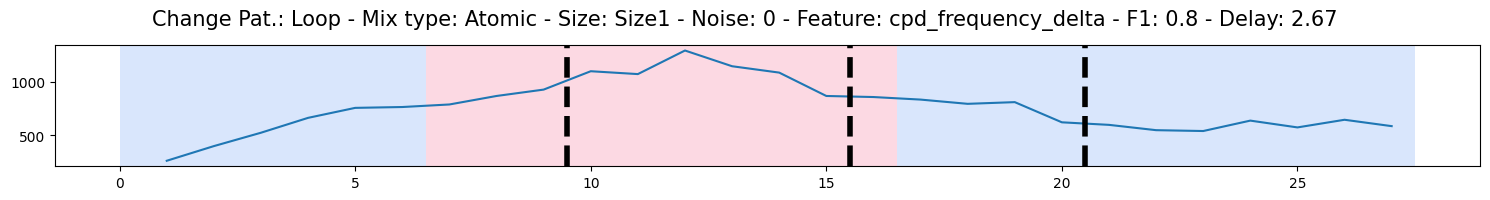

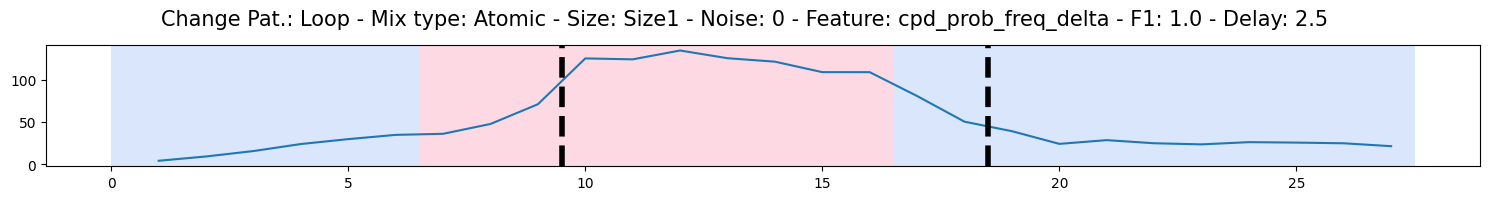

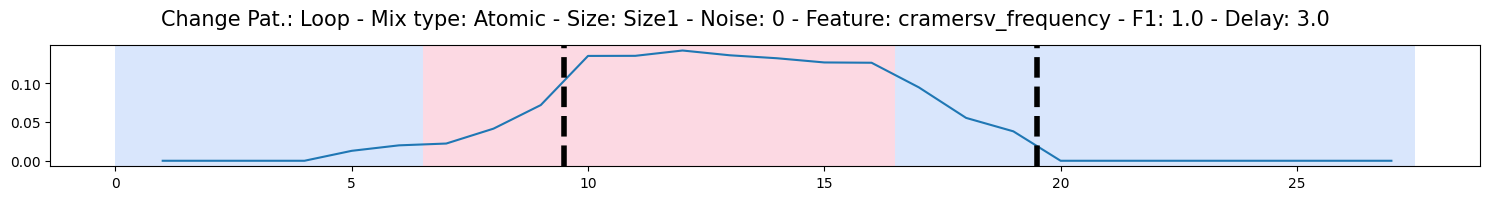

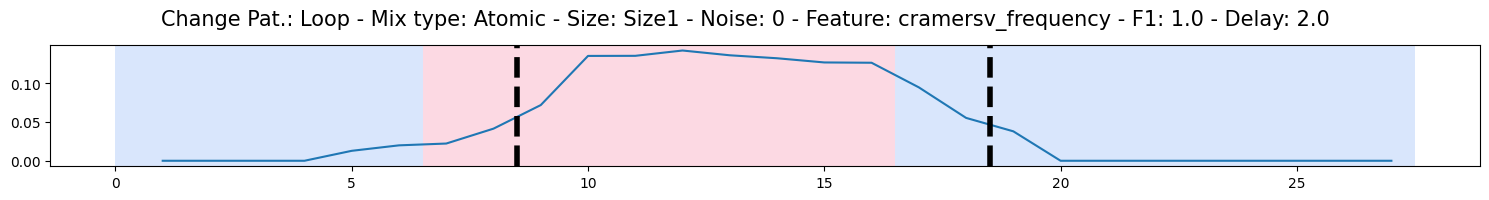

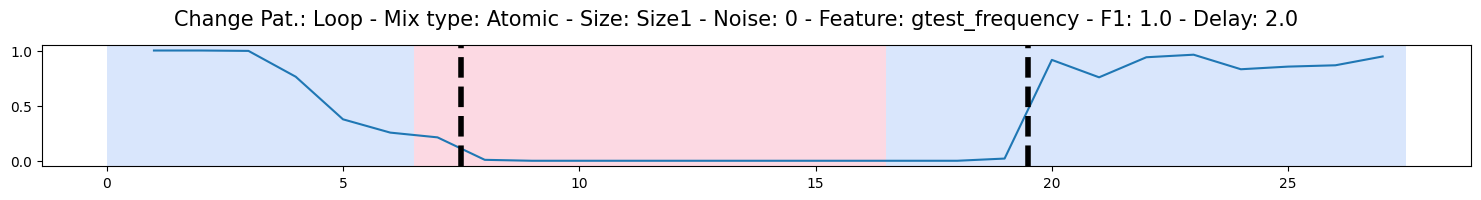

In [12]:
# Display Detection Task Results 
Noise = log_path.split("\\")[-1].split(".")[0].split("_")[-1] if log_path.split("\\")[-1].split(".")[0].split("_")[-1].isdigit() else 0

for result in detection_task_results.itertuples():
    fig, axarr = rpt.display(signal = TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result.detection_strategy][result.detection_feature]['change_features']]
                , true_chg_pts=ground_truth
                , computed_chg_pts = result.detection_results
                , computed_chg_pts_color = "k"
                , computed_chg_pts_linewidth = 4
                , computed_chg_pts_linestyle = "--"
                , computed_chg_pts_alpha = 1
                , figsize=(15, 2)
                )
    plt.suptitle("Change Pat.: " + str(log_path.split("\\")[-3])   
                 + " - Mix type: " + str(log_path.split("\\")[-4])  
                 + " - Size: " + str(log_path.split("\\")[-5]) 
                 + " - Noise: " + str(Noise)
                 + " - Feature: " + str(result.detection_feature) 
                 + " - F1: " + str(result.f1) 
                 + " - Delay: " + str(result.delay)
                 , fontsize=15)
    plt.subplots_adjust(top=0.8)
    plt.show()

## Step 6a - Setting Localization Task

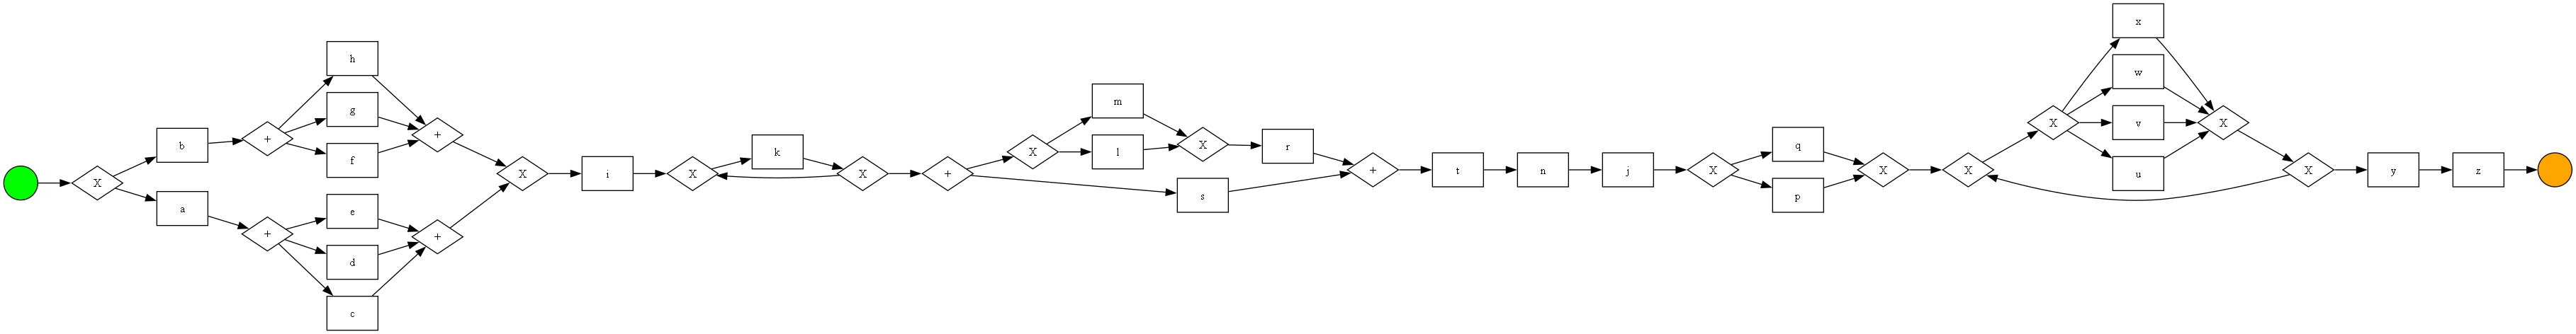

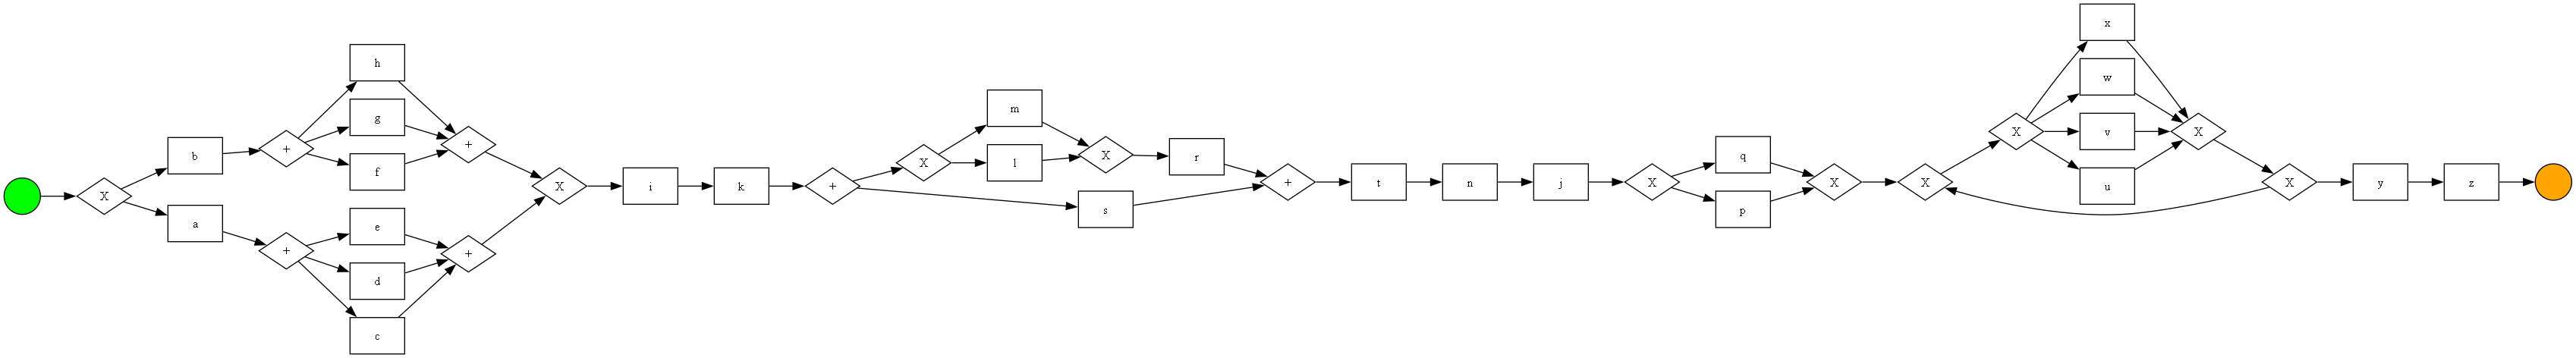

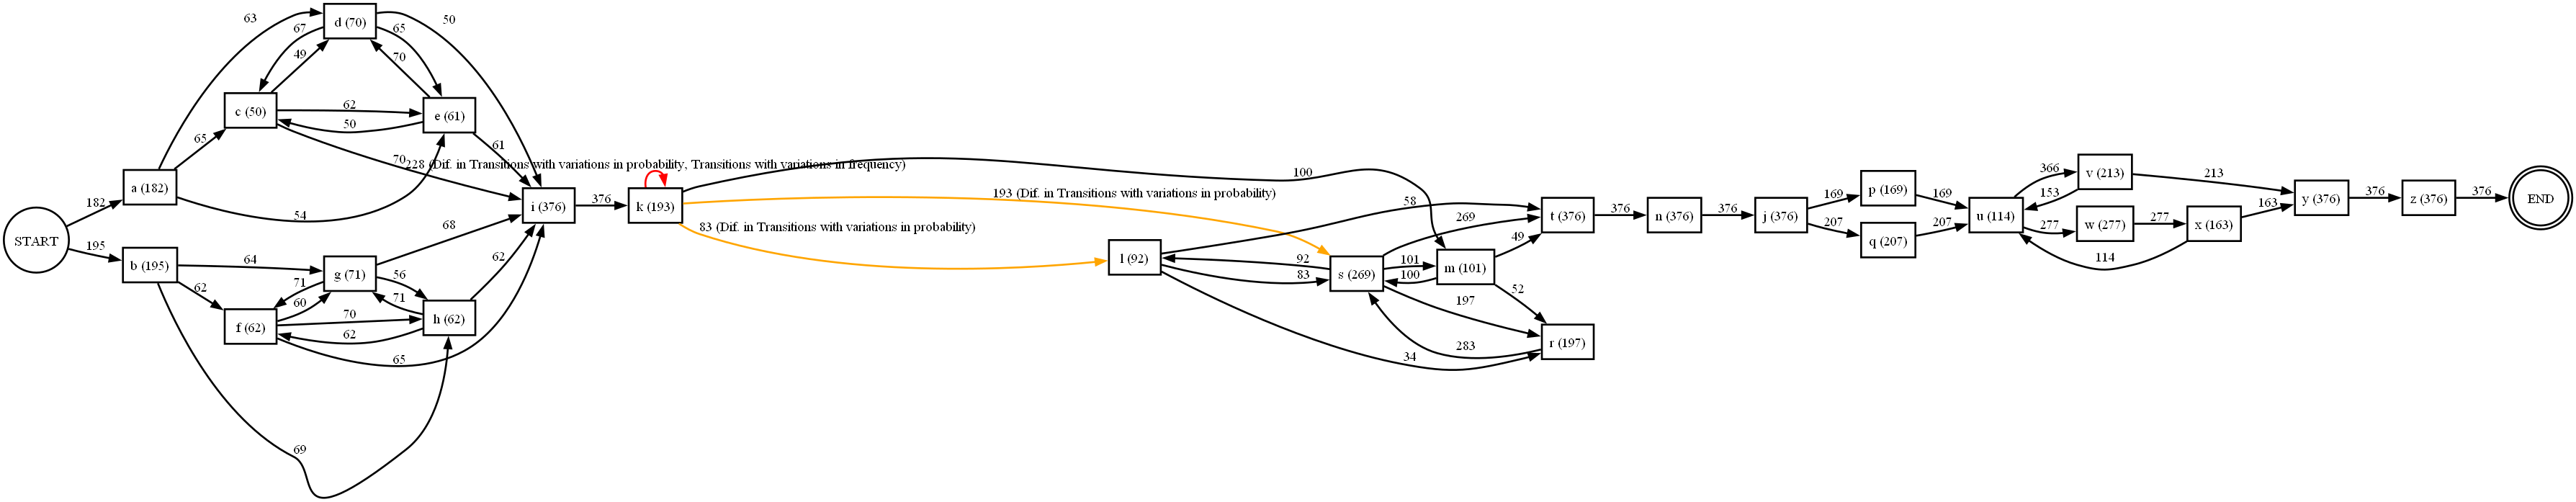

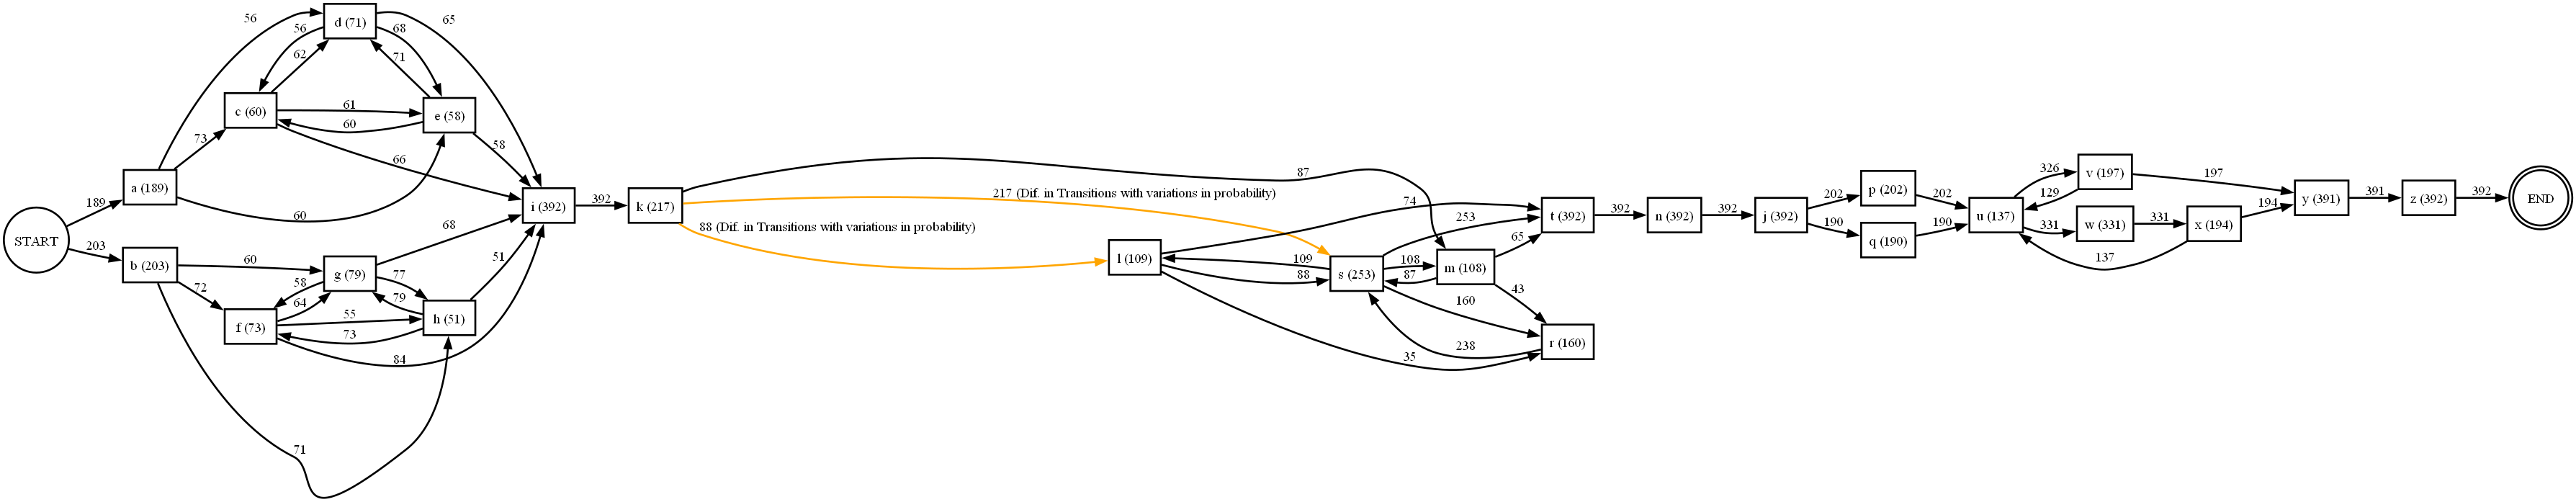

(  transition      feature  p_value  effect_size  ref_value  det_value  \
 0     (k, k)  probability   0.0000       1.3232     0.3775     0.0000   
 1     (k, k)    frequency   0.0000       0.1395   228.0000     0.0000   
 2     (k, l)  probability   0.0003      -0.2277     0.1374     0.2245   
 3     (k, s)  probability   0.0000      -0.4766     0.3195     0.5536   
 
    dif_value  
 0    -0.3775  
 1  -228.0000  
 2     0.0871  
 3     0.2340  ,
 {'Transitions with variations in probability': [('k', 'k'),
   ('k', 'l'),
   ('k', 's')],
  'Transitions with variations in frequency': [('k', 'k')],
  'New transitions added to the process': ['None'],
  'Deleted transitions from the process': [('k', 'k')],
  'New activities added to the process': ['None'],
  'Deleted activities from the process': ['None'],
  'New start activities added to the process': ['None'],
  'Deleted start activities from the process': ['None'],
  'New end activities added to the process': ['None'],
  'Deleted end a

In [13]:
# Setting Localization Task
TMPD_instance.set_localization_task(reference_window_index=0, detection_window_index=14, pvalue_threshold=0.05, effect_prop_threshold=0.2, effect_count_threshold=0.02, pseudo_count=5)

# Executing Localization Task
TMPD_instance.run_localization_task()

# Showing Localization Task Results
TMPD_instance.get_localization_task(show_localization_dfg=True, show_original_dfg=False, show_original_bpmn=True)

In [14]:
### Ground Truth
change_pattern_ground_truth = log_path.split("\\")[-3]

change_activities_ground_truth = {
    'ConditionalMove': {
        'change_pattern_name': 'CM',
        'characterization_activities': ['Prepare_acceptance_pack'],
        'localization_activities': ['Send_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    'ConditionalRemoval': {
        'change_pattern_name': 'CRE',
        'characterization_activities': ['Prepare_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Verify_repayment_agreement'],
        'localization_activities': ['Send_acceptance_pack', 'Cancel_application', 'Check_if_home_insurance_quote_is_requested', 'Approve_application', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    'ConditionalToSequence': {
        'change_pattern_name': 'CF',
        'characterization_activities': ['Send_home_insurance_quote', 'Send_acceptance_pack'],
        'localization_activities': ['Check_if_home_insurance_quote_is_requested', 'Send_home_insurance_quote', 'Send_acceptance_pack', 'Verify_repayment_agreement']
    },
    'Frequency': {
        'change_pattern_name': 'FR',
        'characterization_activities': ['Check_if_home_insurance_quote_is_requested', 'Send_acceptance_pack', 'Send_home_insurance_quote'],
        'localization_activities': ['Check_if_home_insurance_quote_is_requested', 'Send_home_insurance_quote', 'Send_acceptance_pack', 'Verify_repayment_agreement']
    },
    'Loop': {
        'change_pattern_name': 'LP',
        'characterization_activities': ['Assess_loan_risk', 'Appraise_property', 'Assess_eligibility', 'Check_credit_history'],
        'localization_activities': ['Assess_loan_risk', 'Appraise_property', 'Assess_eligibility', 'Check_credit_history', 'Reject_application', 'Prepare_acceptance_pack']
    },
    'ParallelMove': {
        'change_pattern_name': 'PM',
        'characterization_activities': ['Prepare_acceptance_pack', 'Send_home_insurance_quote'],
        'localization_activities': ['Send_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    'ParallelRemoval': {
        'change_pattern_name': 'PRE',
        'characterization_activities': ['Prepare_acceptance_pack', 'Send_home_insurance_quote'],
        'localization_activities': ['Send_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    'ParallelToSequence': {
        'change_pattern_name': 'PL',
        'characterization_activities': ['Appraise_property', 'Check_credit_history', 'Assess_loan_risk'],
        'localization_activities': ['Assess_loan_risk', 'Check__application__form_completeness', 'Appraise_property', 'Assess_eligibility', 'Check_credit_history']
    },
    'SerialMove': {
        'change_pattern_name': 'SM',
        'characterization_activities': ['Assess_eligibility'],
        'localization_activities': ['Assess_eligibility', 'Reject_application', 'Prepare_acceptance_pack', 'Assess_loan_risk', 'Appraise_property']
    },
    'SerialRemoval': {
        'change_pattern_name': 'SRE',
        'characterization_activities': ['Assess_eligibility'],
        'localization_activities': ['Assess_eligibility', 'Reject_application', 'Prepare_acceptance_pack', 'Assess_loan_risk', 'Appraise_property']
    },
    'Skip': {
        'change_pattern_name': 'CB',
        'characterization_activities': ['Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack'],
        'localization_activities': ['Send_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote']
    },
    'Substitute': {
        'change_pattern_name': 'RP',
        'characterization_activities': ['Verify_repayment_agreement', 'Replaced_Activity'],
        'localization_activities': ['Cancel_application', 'Send_acceptance_pack', 'Replaced_Activity', 'Approve_application', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    'Swap': {
        'change_pattern_name': 'SW',
        'characterization_activities': ['Prepare_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Verify_repayment_agreement'],
        'localization_activities': ['Send_acceptance_pack', 'Cancel_application', 'Check_if_home_insurance_quote_is_requested', 'Approve_application', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    } 
}

localization_ground_truth = change_activities_ground_truth[change_pattern_ground_truth]['localization_activities']
localization_ground_truth

['Assess_loan_risk',
 'Appraise_property',
 'Assess_eligibility',
 'Check_credit_history',
 'Reject_application',
 'Prepare_acceptance_pack']

In [15]:
### Validation metrics

# Getting the distinct activities in the Localization Result
localization_distinct_activities = set()
for key, value in islice(TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[1].items(), 6):
    if isinstance(value, list): # Check if the value is a list
        # Skip the list if it contains only "None"
        if len(value) == 1 and value[0] == "None":
            continue
        for item in value:
            if isinstance(item, tuple): # If the items are tuples, extend the set with the tuple items
                localization_distinct_activities.update(item)
            else: # If the items are not tuples (i.e., strings), add them directly to the set
                localization_distinct_activities.add(item)
localization_result = list(localization_distinct_activities)
print(localization_result)

# Set comparison for 'Activities'
precision, recall, f1_score = TMPD_utils.list_match_metrics(localization_ground_truth, localization_result)

localization_task_validation_results = ({
    'localization_activities_precision': precision,
    'localization_activities_recall': recall,
    'localization_activities_f1_score': f1_score
})

localization_task_validation_results

['k', 'l', 's']


{'localization_activities_precision': 0.0,
 'localization_activities_recall': 0.0,
 'localization_activities_f1_score': 0}

## Step 6b - Setting Characterization Task

In [16]:
# Setting Characterization Task
TMPD_instance.set_characterization_task(llm_company = "openai", llm_model="gpt-4o", api_key_path='Temp/openai_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_v7.yaml') # "gpt-4o", "gpt-4-1106-preview", "gpt-3.5-turbo-0125", "gpt-4"
# TMPD_instance.set_characterization_task(llm_company = "google", llm_model="gemini-pro", api_key_path='Temp/google_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_v4.yaml')

# Executing Characterization Task
TMPD_instance.run_characterization_task()

# Showing Characterization Task Results
TMPD_instance.get_characterization_task()

################################ llm_bpmn_analysis_response #####################################
### Analysis of BPMN Diagrams Before and After Concept Drift ###

#### BPMN Before Concept Drift ####
```
->( 
    X( 
        ->( 'a', +( 'e', 'c', 'd' ) ), 
        ->( 'b', +( 'f', 'g', 'h' ) ) 
    ), 
    'i', 
    *( 'k', tau ), 
    +( 's', ->( X( 'm', 'l' ), 'r' ) ), 
    't', 
    'n', 
    'j', 
    X( 'p', 'q' ), 
    *( X( 'v', 'w', 'x', 'u' ), tau ), 
    'y', 
    'z' 
)
```

#### BPMN After Concept Drift ####
```
->( 
    X( 
        ->( 'a', +( 'e', 'c', 'd' ) ), 
        ->( 'b', +( 'f', 'g', 'h' ) ) 
    ), 
    'i', 
    'k', 
    +( 's', ->( X( 'm', 'l' ), 'r' ) ), 
    't', 
    'n', 
    'j', 
    X( 'p', 'q' ), 
    *( X( 'v', 'w', 'x', 'u' ), tau ), 
    'y', 
    'z' 
)
```

### Key Differences and Analysis ###

1. **Loop Fragment Removal:**
   - **Before Drift:** `*( 'k', tau )`
   - **After Drift:** `'k'`
   - **Analysis:** The loop fragment containing 'k' and a 

({'concept_drift': ['Yes'], 'change_pattern': ['LP'], 'activities': ['k']},
 "### Step-by-Step Analysis ###\n\n#### Step 1: Confirming Concept Drift ####\nBased on the provided analysis, it is clear that a concept drift has occurred. The primary evidence is the removal of the loop fragment containing 'k' and the silent transition (tau), making 'k' mandatory.\n\n#### Step 2: Identifying the Change Pattern ####\nThe change pattern that best fits the observed changes is the **Loop (LP)** pattern. This is because the loop fragment `*( 'k', tau )` has been removed, altering the loopability of 'k' without fundamentally changing the relational dynamics among the activities.\n\n#### Step 3: Identifying the Involved Activities ####\nThe activity involved in this change is 'k'.\n\n### Final Result ###\n```python\n### result_dict = {'concept_drift' : ['Yes'], 'change_pattern' : ['LP'], 'activities' : ['k']}\n```\n\nThis result indicates that a concept drift has occurred, classified as a Loop (LP)

In [17]:
### Ground Truth

characterization_ground_truth = {'concept_drift' : ['Yes'], 'change_pattern' : [change_activities_ground_truth[change_pattern_ground_truth]['change_pattern_name']], 'activities' : change_activities_ground_truth[change_pattern_ground_truth]['characterization_activities']}
characterization_ground_truth

{'concept_drift': ['Yes'],
 'change_pattern': ['LP'],
 'activities': ['Assess_loan_risk',
  'Appraise_property',
  'Assess_eligibility',
  'Check_credit_history']}

In [18]:
### Validation metrics

characterization_result = TMPD_instance.get_characterization_task()[0]

# Initialize a results dictionary
characterization_task_validation_results = {
    'characterization_concept_drift_match': None,
    'characterization_change_pattern_match_f1_score': None,
    'characterization_change_pattern_match_precision': None,
    'characterization_change_pattern_match_recall': None,
    'characterization_activities_precision': None,
    'characterization_activities_recall': None,
    'characterization_activities_f1_score': None
}

# Check matches
try:
    characterization_task_validation_results['characterization_concept_drift_match'] = TMPD_utils.list_match_metrics(characterization_ground_truth['concept_drift'], characterization_result['concept_drift'])[2]
except:
    characterization_task_validation_results['characterization_concept_drift_match'] = -1

try:
    precision, recall, f1_score = TMPD_utils.list_match_metrics(characterization_ground_truth['change_pattern'], characterization_result['change_pattern'])
    characterization_task_validation_results.update({
        'characterization_change_pattern_match_f1_score': f1_score,
        'characterization_change_pattern_match_precision': precision,
        'characterization_change_pattern_match_recall': recall
    })

except:
    characterization_task_validation_results.update({
        'characterization_change_pattern_match_f1_score': -1,
        'characterization_change_pattern_match_precision': -1,
        'characterization_change_pattern_match_recall': -1
    })

# Set comparison for 'Activities'
precision, recall, f1_score = TMPD_utils.list_match_metrics(characterization_ground_truth['activities'], characterization_result['activities'])

characterization_task_validation_results.update({
    'characterization_activities_precision': precision,
    'characterization_activities_recall': recall,
    'characterization_activities_f1_score': f1_score
})

characterization_task_validation_results


{'characterization_concept_drift_match': 1.0,
 'characterization_change_pattern_match_f1_score': 1.0,
 'characterization_change_pattern_match_precision': 1.0,
 'characterization_change_pattern_match_recall': 1.0,
 'characterization_activities_precision': 0.0,
 'characterization_activities_recall': 0.0,
 'characterization_activities_f1_score': 0}

In [19]:
understanding_tasks_results = pd.DataFrame([{**characterization_task_validation_results}])
understanding_tasks_results['localization_activities'] = ', '.join(localization_result) 
understanding_tasks_results['characterization_change_pattern'] = ', '.join(TMPD_instance.get_characterization_task()[0]['change_pattern']) 
understanding_tasks_results['characterization_activities'] = ', '.join(TMPD_instance.get_characterization_task()[0]['activities']) 
understanding_tasks_results['localization_changes'] = [TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[1]]
understanding_tasks_results['reference_bpmn_text'] = TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[2]
understanding_tasks_results['detection_bpmn_text'] = TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[3]
understanding_tasks_results['change_patterns_llm_response'] = TMPD_instance.get_characterization_task()[1]
understanding_tasks_results

,characterization_concept_drift_match,characterization_change_pattern_match_f1_score,characterization_change_pattern_match_precision,characterization_change_pattern_match_recall,characterization_activities_precision,characterization_activities_recall,characterization_activities_f1_score,localization_activities,characterization_change_pattern,characterization_activities,localization_changes,reference_bpmn_text,detection_bpmn_text,change_patterns_llm_response
0,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0,"k, l, s",LP,k,"{'Transitions with variations in probability': [('k', 'k'), ('k', 'l'), ('k', 's')], 'Transitions with variations in frequency': [('k', 'k')], 'Ne...","->( X( ->( 'a', +( 'e', 'c', 'd' ) ), ->( 'b', +( 'f', 'g', 'h' ) ) ), 'i', *( 'k', tau ), +( 's', ->( X( 'm', 'l' ), 'r' ) ), 't', 'n', 'j', X( '...","->( X( ->( 'a', +( 'e', 'c', 'd' ) ), ->( 'b', +( 'f', 'g', 'h' ) ) ), 'i', 'k', +( 's', ->( X( 'm', 'l' ), 'r' ) ), 't', 'n', 'j', X( 'p', 'q' ),...","### Step-by-Step Analysis ###\n\n#### Step 1: Confirming Concept Drift ####\nBased on the provided analysis, it is clear that a concept drift has ..."


## Step 6c - Setting Explanation Task

In [20]:
# TODO